In [1]:
import sys
sys.path.append("../..")
from IPython.display import display
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import numpy as np

import magine.data.tools as dt

from magine.plotting.heatmaps import  heatmap_from_array
from magine.plotting.wordcloud_tools import create_wordcloud
from magine.plotting.venn_diagram_maker import create_venn2, create_venn3
from magine.plotting.species_plotting import plot_species

In [3]:
# load the experimental data
from exp_data import exp_data


# Visualize experimental data


In [4]:
display(exp_data.create_table_of_data())
display(exp_data.create_table_of_data(sig=True))
display(exp_data.create_table_of_data(sig=True, unique=True))

sample_id,01hr,06hr,24hr,48hr,Total Unique Across
source,,,,,
C18,528.0,227.0,657.0,689,1402
HILIC,479.0,611.0,941.0,621,1504
label_free,3135.0,3091.0,2735.0,2504,3447
ph_silac,6903.0,10956.0,12176.0,11183,5113
rna_seq,18741.0,19104.0,19992.0,-,20642
silac,2923.0,3357.0,3072.0,3265,4086


sample_id,01hr,06hr,24hr,48hr,Total Unique Across
source,,,,,
C18,528.0,227.0,657.0,689,1402
HILIC,479.0,611.0,941.0,621,1504
label_free,201.0,46.0,281.0,911,1085
ph_silac,594.0,1370.0,2414.0,1368,2278
rna_seq,73.0,1999.0,12215.0,-,12340
silac,38.0,52.0,228.0,266,485


sample_id,01hr,06hr,24hr,48hr,Total Unique Across
source,,,,,
C18,522.0,227.0,653.0,685,1412
HILIC,471.0,605.0,930.0,613,1521
label_free,196.0,46.0,271.0,874,1149
ph_silac,514.0,888.0,1227.0,851,4757
rna_seq,73.0,1999.0,12215.0,-,12340
silac,38.0,52.0,228.0,266,485


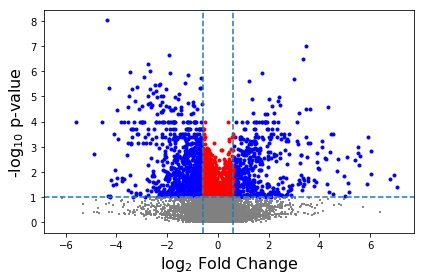

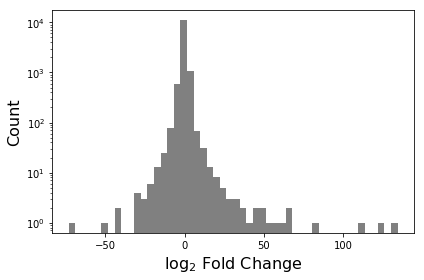

In [5]:
v_plot = exp_data.label_free.volcano_plot(save_name='lf_volcano')
hist_plot = exp_data.create_histogram_measurements('label_free', 'hist')

In [6]:
data = exp_data.data.copy()
data = data[data['source'].isin(['label_free', 'rna_seq'])]
data = dt.log2_normalize_df(data, 'fold_change')

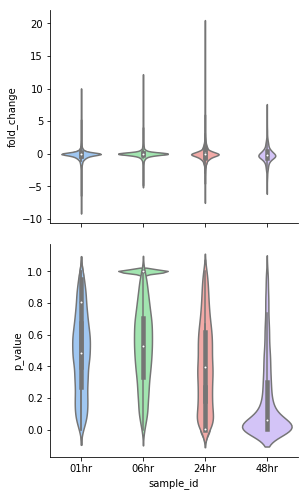

In [7]:
g = sns.PairGrid(data,
                 x_vars=['sample_id'],
                 y_vars=['fold_change', 'p_value'],
                 hue='source',
                 aspect=1.25, size=3.5)
g.map(sns.violinplot, palette="pastel", split=True,);
g.fig.savefig('violin_plot-lf_rna_over_time.png', dpi=300)

array(['label_free'], dtype=object)

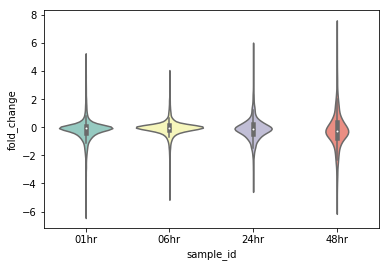

In [8]:
lf = exp_data.label_free
lf = dt.log2_normalize_df(lf, 'fold_change')
g = sns.violinplot(x="sample_id", y="fold_change", data=lf,
                   palette="Set3", order=sorted(lf['sample_id'].unique()) )

plt.savefig("violin_plot.png", dpi=300)
display(exp_data.label_free['source'].unique())

In [9]:
met = exp_data.compounds.copy()
proteins = exp_data.proteins.copy()
rna_seq = exp_data.rna.copy()

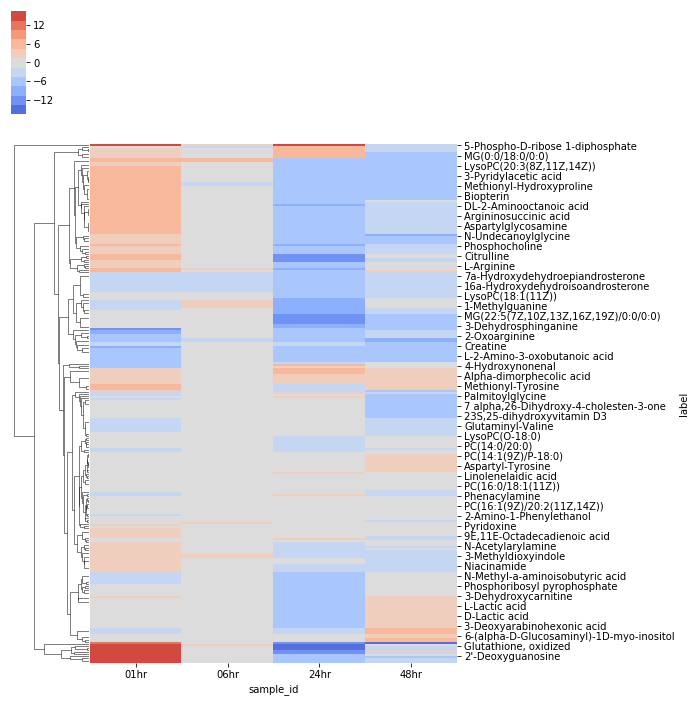

In [10]:
met_sig = met.filter_by_minimum_sig_columns(
    index='identifier', 
    columns='sample_id', 
    min_terms=4
)
fig = heatmap_from_array(met_sig, cluster_row=True, convert_to_log=True, 
                         index='label', values='fold_change', 
                         columns='sample_id', div_colors=True,
                         fig_size=(8, 12), num_colors=11)


plt.savefig('metabolomics_clustered.png', dpi=300, bbox_inches='tight')

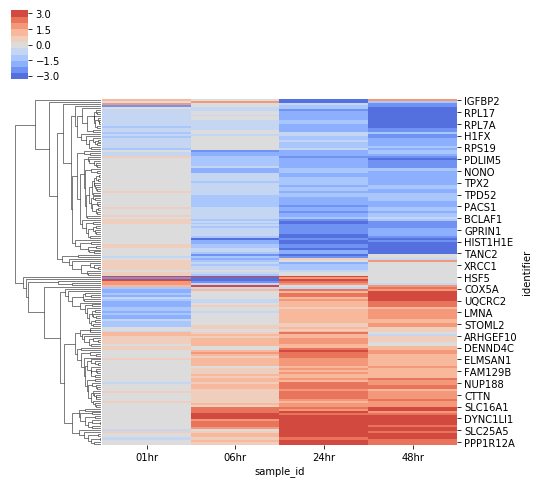

In [11]:
proteins.loc[proteins['fold_change']>10, 'fold_change']=10
proteins.loc[proteins['fold_change']<-10, 'fold_change']=-10

proteins_sig = proteins.filter_by_minimum_sig_columns(
    index='label', 
    columns='sample_id', 
    min_terms=3
)
fig = heatmap_from_array(proteins_sig, cluster_row=True, convert_to_log=True, 
                         index='identifier', values='fold_change', 
                         columns='sample_id', div_colors=True, fig_size=(8, 8),  num_colors=11)

fig.fig.savefig('proteins_clustered_time.png', dpi=250, bbox_inches='tight')

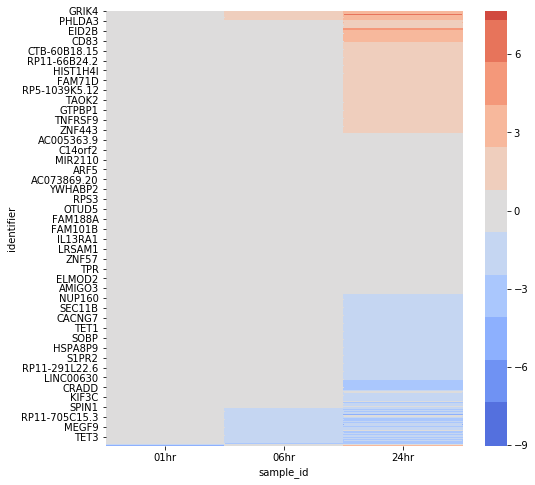

In [12]:
fig = heatmap_from_array(rna_seq.sig, convert_to_log=True, cluster_row=False, 
                         index='identifier', values='fold_change', 
                         columns='sample_id', div_colors=True, fig_size=(8, 8), num_colors=11)

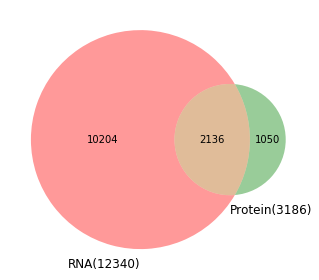

In [13]:
create_venn2(exp_data.rna.sig.id_list,
             exp_data.proteins.sig.id_list, 
             'RNA', 'Protein', 'venn_rna_and_protein');

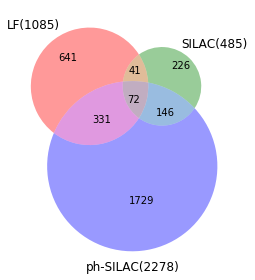

In [14]:
lf = exp_data.label_free.sig.id_list
silac = exp_data.silac.sig.id_list
phsilac = exp_data.ph_silac.sig.id_list

create_venn3(lf, silac, phsilac, 
             'LF', 'SILAC', 'ph-SILAC', 'venn_proteomics');

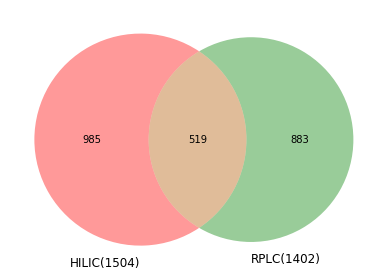

In [15]:
hilic = exp_data.HILIC.sig.id_list
rplc = exp_data.C18.sig.id_list

create_venn2(hilic, rplc, 'HILIC', 'RPLC', 'venn_metabolomics');

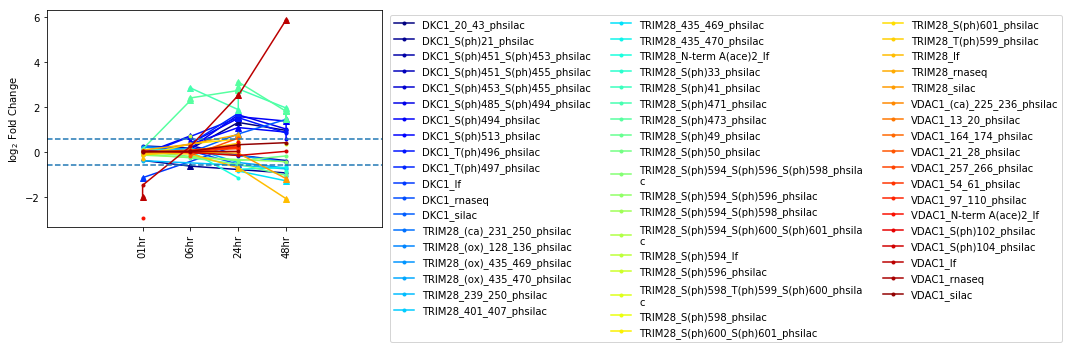

In [16]:
exp_data.species.plot_species(
    ['VDAC1', 'TRIM28', 'DKC1'], 
    plot_type='matplotlib', 
    save_name='proteins_timecoure_example', 
    image_format='png'
);

In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
for i in exp_data.rna.sig.by_sample:
    print(len(i))
print(exp_data.rna.sig.sample_ids)

35
1532
6057
['01hr', '06hr', '24hr']


In [ ]:
from magine.enrichment.enrichr import Enrichr


e = Enrichr()

In [ ]:
down_tf = e.run_samples(exp_data.rna.sig.down_by_sample,
                        sample_ids=exp_data.rna.sig.sample_ids,
                   database='ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X')

In [ ]:
down_tf['significant_flag'] = False
crit = (down_tf['adj_p_value']<0.05) & (down_tf['combined_score']>1) 
down_tf.loc[crit, 'significant_flag'] = True

down_tf.filter_by_minimum_sig_columns(columns='sample_id', min_terms=1, inplace=True)

down_tf.remove_redundant(level='all', inplace=True)
down_tf.dist_matrix(level='all');
down_tf.sort_values('combined_score', inplace=True, ascending=False)

In [72]:
down_tf.head(15)

,term_name,rank,p_value,z_score,combined_score,adj_p_value,genes,n_genes,db,sample_id,significant_flag
48,ubtf_encode,1,3.614420e-48,-1.672192,182.668873,3.758997e-46,"ABCC4,ADAM10,ADCY9,AEBP2,AFF1,AFF4,AGFG1,AGPAT...",296,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,06hr,True
152,ubtf_encode,1,2.479910e-42,-1.672192,160.196612,2.579107e-40,"AAED1,ABCC4,ABCD3,ABHD12,ABHD17C,ACER3,ACSL3,A...",744,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True
153,e2f4_encode,2,2.908563e-40,-1.733200,157.783152,1.512453e-38,"ADSS,AGFG2,AHCTF1,ALG8,ALMS1,ANKRD32,ANP32E,AP...",382,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True
49,ar_chea,2,2.968436e-40,-1.597038,145.354961,1.543587e-38,"ABCA1,ABCC1,ABCC4,ABHD2,ABTB2,AFAP1L2,AGPAT3,A...",216,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,06hr,True
154,ar_chea,3,3.336081e-36,-1.561805,127.581177,1.156508e-34,"ABCC1,ABCC4,ABCD3,ABHD2,ABLIM3,ABTB2,ACKR3,ACO...",524,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True
50,smad4_chea,3,3.938244e-34,-1.637426,125.946190,1.023944e-32,"AFAP1,AFAP1L2,ALCAM,ANKS1B,ARHGAP26,ARHGEF11,A...",138,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,06hr,True
51,gata1_chea,4,3.134375e-35,-1.558270,123.801500,1.086583e-33,"ABCC4,ABHD2,ACVR1,AFF1,AGPAT4,ANKRD27,ANKRD33B...",170,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,06hr,True
155,smad4_chea,4,3.501138e-21,-1.637426,77.124749,9.102960e-20,"ACTN1,ACTR3,ADAMTS16,ADD1,AFAP1,AFAP1L2,AGFG2,...",284,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True
52,gata2_chea,5,2.003368e-18,-1.600315,65.215549,4.167006e-17,"ABCC1,ABHD2,AGPAT3,AGPAT9,ANKRD27,ARHGAP12,ARI...",131,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,06hr,True
156,nfe2l2_chea,5,3.089052e-19,-1.494847,63.712262,6.425228e-18,"AACS,ABCC1,ABCC2,ABCC4,ABHD12,ABI1,ACACB,ACAP2...",441,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True


# UBTF down regulation is necessary for cisplatin induced apoptosis
*Here we show that displacement of UBF and ablation of rRNA synthesis are very early effects of cisplatin treatment, and that in the absence of cisplatin, elimination of UBF protein is sufficient to induce fully penetrant apoptotic cell death.*

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4695006/


In [76]:
df = e.run(down_tf.term_to_genes('ubtf_encode'))
df.head(15)

,term_name,rank,p_value,z_score,combined_score,adj_p_value,genes,n_genes,db
0,positive regulation of transcription from rna ...,1,3.639444e-10,-6.496137,141.187167,5.528315e-07,"ASXL2,ATAD2,ATAD2B,BMPR1A,BMPR2,CAMTA1,CDC73,C...",63,GO_Biological_Process_2017
1,negative regulation of transcription from rna ...,2,1.519189e-08,-5.351170,96.334462,7.692163e-06,"BEND3,CBX2,CBX6,CDC73,CNOT2,CTCF,DLG1,E2F8,EP3...",45,GO_Biological_Process_2017
2,protein phosphorylation,3,2.332474e-09,-4.427083,87.994185,1.771514e-06,"ADAM10,BMPR1A,CDC42BPA,CDK6,COL4A3BP,CREB1,DAP...",36,GO_Biological_Process_2017
3,intracellular signal transduction,4,1.349347e-06,-3.954984,53.455129,4.171453e-04,"ANP32A,ARFGEF2,CAB39,CAMK1D,CARHSP1,DAPK2,GSK3...",26,GO_Biological_Process_2017
4,signal transduction,5,3.669605e-04,-5.731259,45.335729,1.922114e-02,"ADCY9,AKAP9,CBLB,CDK6,CORO1C,CREB1,DEK,GKAP1,G...",53,GO_Biological_Process_2017
5,"positive regulation of transcription, dna-temp...",6,9.353820e-05,-4.783414,44.376408,7.893585e-03,"ARID1A,ATAD2,AXIN1,CREB1,CTCF,CTNNB1,FOXO1,FOX...",35,GO_Biological_Process_2017
6,regulation of transcription from rna polymeras...,7,3.323383e-05,-4.216839,43.483805,3.883245e-03,"ARID1A,ATAD2,BRWD1,CHD4,CITED4,CNOT2,DEK,FOXO3...",27,GO_Biological_Process_2017
7,protein deubiquitination,8,1.443937e-05,-3.860463,43.026986,2.537135e-03,"ASXL2,ATXN7,AXIN1,CCNA2,EP300,FOXK1,INO80D,KAT...",24,GO_Biological_Process_2017
8,negative regulation of apoptotic process,9,2.676046e-04,-4.284002,35.240196,1.813251e-02,"AVEN,DHCR24,DNAJC3,FOXO1,GCLC,GSK3B,HNRNPK,IGF...",26,GO_Biological_Process_2017
9,vascular endothelial growth factor receptor si...,10,1.373092e-06,-2.510935,33.893725,4.171453e-04,"ACTG1,BMPR2,CYFIP1,ITGAV,MAPKAPK2,NCK1,NCKAP1,...",13,GO_Biological_Process_2017


Number of rows went from 133 to 124


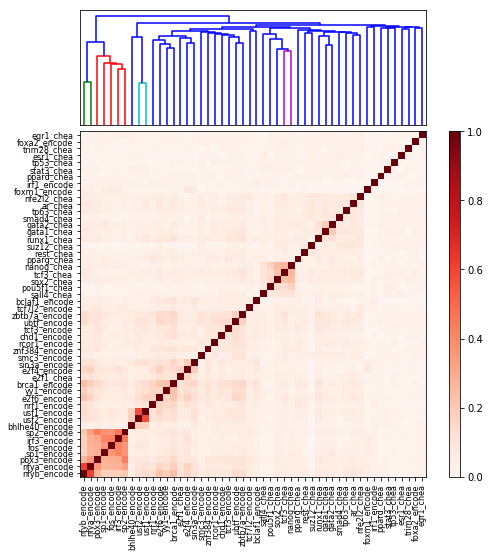

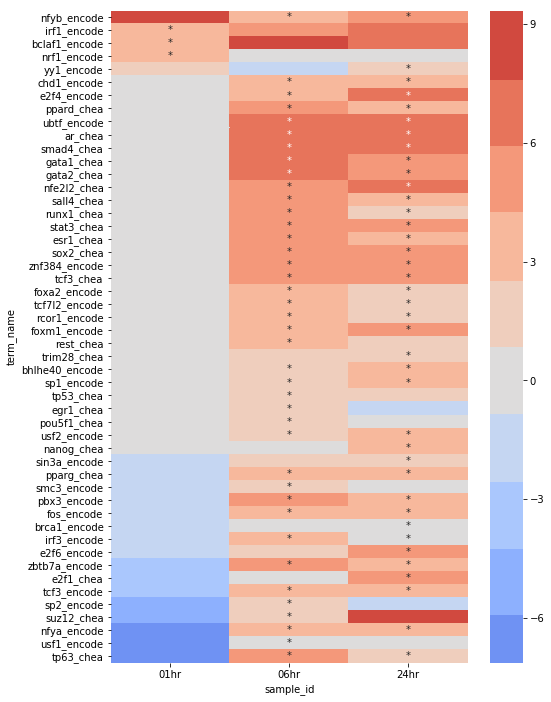

In [67]:
fig = heatmap_from_array(down_tf, convert_to_log=True, cluster_row=False, 
                         index='term_name', values='combined_score', 
                         columns='sample_id', div_colors=True, 
                         annotate_sig=True,
                         fig_size=(8, 12), num_colors=11)

In [ ]:
for i in exp_data.rna.sig.up_by_sample:
    print(len(i))
    

In [68]:
up_tf.head(10)

,term_name,rank,p_value,z_score,combined_score,adj_p_value,genes,n_genes,db,sample_id,significant_flag
180,gabpa_encode,1,4.549144e-21,-1.751140,82.022258,4.731110e-19,"ABCD4,ABHD17A,ACBD3,ACVR2A,ADO,ADPRHL2,ADPRM,A...",832,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True
181,elf1_encode,2,2.465601e-14,-1.679807,52.634671,1.282112e-12,"AAMP,AARSD1,ABCD1,ABCD4,ABT1,ACOX1,ADPRM,AGBL2...",930,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True
77,tp53_chea,1,2.237032e-11,-1.678524,41.162932,2.304143e-09,"ADRB2,ATF3,BBC3,BLOC1S2,BTG2,CCNG1,CDKN1A,DDB2...",31,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,06hr,True
182,fli1_encode,3,7.096760e-11,-1.642336,38.379429,2.460210e-09,"ABCC10,ADPRM,AEN,AP1S2,ARCN1,ARHGAP1,ARL6IP1,A...",277,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True
183,pml_encode,4,9.869542e-10,-1.690514,35.055178,2.566081e-08,"ACADVL,ACBD3,ACOX1,ADCK3,ADRM1,AFMID,AKAP8,ALD...",600,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True
78,nelfe_encode,2,3.432698e-08,-1.818093,31.248171,1.767839e-06,"CITED2,CSRNP2,EGR1,FAM53C,GADD45A,GDF15,GTF2B,...",22,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,06hr,True
184,creb1_encode,5,7.225489e-09,-1.620683,30.380757,1.502902e-07,"ABCF2,ABHD17A,ABT1,ADAR,ADIPOR1,ADO,ADPRHL2,AI...",808,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True
185,six5_encode,6,7.697978e-07,-1.525011,21.467793,1.334316e-05,"AAMP,ABCC5,ABCF2,ACAD8,ACADVL,ADAT3,ADO,AKT1S1...",410,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True
186,taf1_encode,7,9.883944e-07,-1.508480,20.858029,1.468472e-05,"ABCD4,ABT1,ACBD3,ACIN1,ACOX1,ACTR8,ADCK3,ADPRH...",1148,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True
187,bcl3_encode,8,1.538455e-06,-1.520731,20.354572,1.999991e-05,"ABCA7,ADRM1,AKAP8,ALDH3A1,AMDHD2,ARL6IP1,BBC3,...",121,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,24hr,True


Number of rows went from 67 to 67


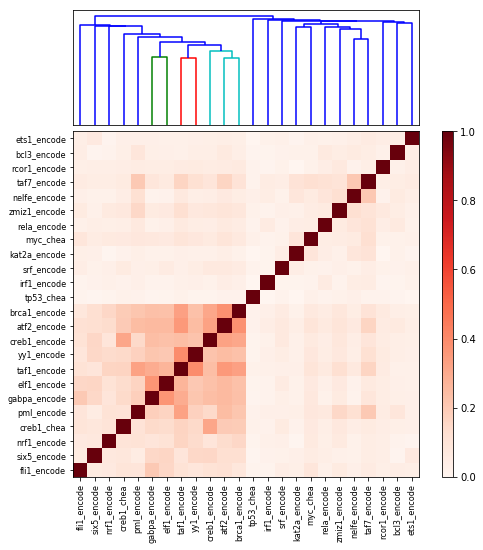

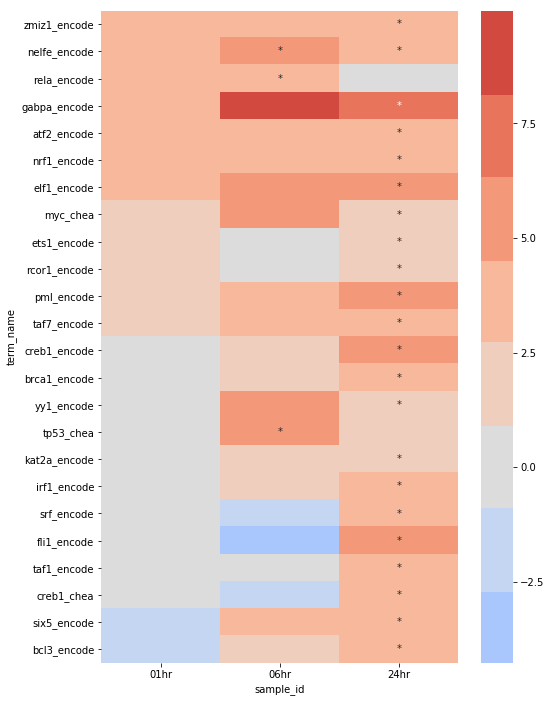

In [66]:
up_tf = e.run_samples(exp_data.rna.sig.up_by_sample,
                   sample_ids=exp_data.rna.sig.sample_ids,
                   database='ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X')


up_tf['significant_flag'] = False
crit = (up_tf['adj_p_value']<=0.05) & (up_tf['combined_score']>1) 
up_tf.loc[crit, 'significant_flag'] = True

up_tf.filter_by_minimum_sig_columns(columns='sample_id', min_terms=1, inplace=True)

up_tf.remove_redundant(level='all', inplace=True)
up_tf.dist_matrix(level='all');
up_tf.sort_values('combined_score', inplace=True, ascending=False)
up_tf.head(10)

fig = heatmap_from_array(up_tf, convert_to_log=True, cluster_row=False, 
                         index='term_name', values='combined_score', 
                         columns='sample_id', div_colors=True, 
                         annotate_sig=True,
                         fig_size=(8, 12), num_colors=11)